# Определение перспективного тарифа для телеком компании

Предстоит сделать предварительный анализ тарифов на небольшой выборке клиентов. В вашем распоряжении данные 500 пользователей «Мегалайна»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. Нужно проанализировать поведение клиентов и сделать вывод — какой тариф лучше.   

##### Описание тарифов
Тариф «Смарт»
- Ежемесячная плата: 550 рублей
- Включено 500 минут разговора, 50 сообщений и 15 Гб интернет-трафика
- Стоимость услуг сверх тарифного пакета:
- минута разговора: 3 рубля
- сообщение: 3 рубля
- 1 Гб интернет-трафика: 200 рублей  


Тариф «Ультра»
- Ежемесячная плата: 1950 рублей
- Включено 3000 минут разговора, 1000 сообщений и 30 Гб интернет-трафика
- Стоимость услуг сверх тарифного пакета:
- минута разговора: 1 рубль
- сообщение: 1 рубль
- 1 Гб интернет-трафика: 150 рублей

### Откроем файлы с данными и изучим общую информацию

In [1]:
import pandas as pd

In [2]:
import matplotlib.pyplot as plt

In [3]:
import numpy as np

In [4]:
from scipy import stats as st

In [5]:
from datetime import datetime

In [6]:
import math

In [7]:
calls = pd.read_csv('/datasets/calls.csv')

In [8]:
calls.head()

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000


In [9]:
calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
id           202607 non-null object
call_date    202607 non-null object
duration     202607 non-null float64
user_id      202607 non-null int64
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


In [10]:
calls['duration'].value_counts()

0.00     39613
4.49       142
5.50       142
6.15       141
6.38       141
         ...  
27.02        1
26.19        1
25.34        1
27.13        1
24.28        1
Name: duration, Length: 2871, dtype: int64

В таблице звонков 202607 сток и 4 столбца, пропусков нет. Необходимо изменить формат столбца с датой на формат `datetime64`.  

В столбце `['duration']` значений с длительностью звонка 0.00 составляет 20% от всего количества данных. На данном этапе сохраним данные о таких звонках.

In [11]:
internet = pd.read_csv('/datasets/internet.csv')

In [12]:
internet.head()

,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,1052.81,2018-09-07,1000
2,2,1000_2,1197.26,2018-06-25,1000
3,3,1000_3,550.27,2018-08-22,1000
4,4,1000_4,302.56,2018-09-24,1000


In [13]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
Unnamed: 0      149396 non-null int64
id              149396 non-null object
mb_used         149396 non-null float64
session_date    149396 non-null object
user_id         149396 non-null int64
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB


В таблице расхода интернет трафика 149396 сток и 5 столбцов, пропусков нет. Необходимо изменить формат столбца с датой на формат `datetime64`.

In [14]:
messages = pd.read_csv('/datasets/messages.csv')

In [15]:
messages.head()

,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000


In [16]:
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
id              123036 non-null object
message_date    123036 non-null object
user_id         123036 non-null int64
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


В таблице сообщений 123036 сток и 3 столбца, пропусков нет. Необходимо изменить формат столбца с датой на формат `datetime64`.

In [17]:
tariffs = pd.read_csv('/datasets/tariffs.csv')

In [18]:
tariffs.head()

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


In [19]:
tariffs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
messages_included        2 non-null int64
mb_per_month_included    2 non-null int64
minutes_included         2 non-null int64
rub_monthly_fee          2 non-null int64
rub_per_gb               2 non-null int64
rub_per_message          2 non-null int64
rub_per_minute           2 non-null int64
tariff_name              2 non-null object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


В таблице сообщений 2 строки и 8 столбцов, пропусков нет. Включает в себя информацию о стоимости и лимитах по тарифам. Можно заметить, что стоимость интернет трафика указана за Гб, а лимит и расход в Мб, следовательно потребуется приведение значений к общей размерности.

In [20]:
users = pd.read_csv('/datasets/users.csv')

In [21]:
users.head()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


In [22]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
user_id       500 non-null int64
age           500 non-null int64
churn_date    38 non-null object
city          500 non-null object
first_name    500 non-null object
last_name     500 non-null object
reg_date      500 non-null object
tariff        500 non-null object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


In [23]:
users['churn_date'].unique()

array([nan, '2018-10-05', '2018-12-18', '2018-11-21', '2018-10-03',
       '2018-10-14', '2018-12-09', '2018-12-11', '2018-12-26',
       '2018-08-31', '2018-12-03', '2018-12-23', '2018-11-07',
       '2018-12-16', '2018-12-20', '2018-11-30', '2018-12-21',
       '2018-08-17', '2018-09-02', '2018-10-04', '2018-11-13',
       '2018-11-22', '2018-10-28', '2018-11-26', '2018-11-27',
       '2018-11-16', '2018-10-27', '2018-12-30', '2018-09-27',
       '2018-12-25', '2018-12-14', '2018-12-24', '2018-09-26',
       '2018-10-25'], dtype=object)

В таблице сообщений 500 сток и 8 столбцов, есть пропуски в столбце `[churn_date]`- дата отключения абонента. Следовательно абоненты с пропущенными значениями все еще являются клиентами компании «Мегалайн». Необходимо изменить формат столбца с датой на формат `datetime64`.

#### Проверим дубликаты в таблицах:

In [24]:
calls.duplicated().sum()

0

In [25]:
internet.duplicated().sum()

0

In [26]:
messages.duplicated().sum()

0

In [27]:
users.duplicated().sum()

0

#### Вывод

Для изучения предоставлено 5 различных файлов с данными. Практически в каждом указан не верный формат столбцов с датой. Значения пропущенны лишь в одной таблице, для абонентов все еще являющимися клиентами компании. Дубликаты отсутствуют.

### Подготовка данных

Приведем столбцы содержащие даты в формат времени, для этого применим метод `to_datetime` к столбцам с датами:

In [28]:
calls['call_date'] = pd.to_datetime(calls['call_date'], format='%Y.%m.%d')

In [29]:
internet['session_date'] = pd.to_datetime(internet['session_date'], format='%Y.%m.%d')

In [30]:
messages['message_date'] = pd.to_datetime(messages['message_date'], format='%Y.%m.%d')

In [31]:
users['reg_date'] = pd.to_datetime(users['reg_date'], format='%Y.%m.%d')

#### Подготовка таблицы - *users*

In [32]:
users.head()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


Экспортируем текущую дату:

In [33]:
current_date = datetime.now().date()

In [34]:
print('Текущая дата:', current_date)

Текущая дата: 2021-05-10


Заменим пропущенные значения в столбце `users['churn_date']` на текущую дату:

In [35]:
users['churn_date'] = users['churn_date'].fillna(current_date)

In [36]:
# Переведем столбец в формат даты
users['churn_date'] = pd.to_datetime(users['churn_date'], format='%Y.%m.%d')

Вычислим количество дней подключения абонентов и выведем отдельный столбец `users['days_connect']`:

In [37]:
users['days_connect'] = users['churn_date'] - users['reg_date']

In [38]:
users.head()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff,days_connect
0,1000,52,2021-05-10,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1081 days
1,1001,41,2021-05-10,Москва,Иван,Ежов,2018-11-01,smart,921 days
2,1002,59,2021-05-10,Стерлитамак,Евгений,Абрамович,2018-06-17,smart,1058 days
3,1003,23,2021-05-10,Москва,Белла,Белякова,2018-08-17,ultra,997 days
4,1004,68,2021-05-10,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra,1092 days


Изменим название столбца `'tariff'` на `'tariff_name'`

In [39]:
users.rename(columns={'tariff':'tariff_name'}, inplace=True)

Создадим таблицу со всеми пользователями и подключенному у него тарифу:

In [40]:
users_tariff = users.loc[:, ['user_id', 'tariff_name']]

In [41]:
users_tariff.head()

,user_id,tariff_name
0,1000,ultra
1,1001,smart
2,1002,smart
3,1003,ultra
4,1004,ultra


Создадим функцию по установке статуса абонента - действующий/отключившийся:

In [42]:
def status(row):
    if row == current_date:
        return 'действующий'
    else:
        return 'отключившийся'

Добавим столбец `users['status_user']` в таблицу:

In [43]:
users['status_user'] = users['churn_date'].apply(status)

In [44]:
users.head()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff_name,days_connect,status_user
0,1000,52,2021-05-10,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1081 days,действующий
1,1001,41,2021-05-10,Москва,Иван,Ежов,2018-11-01,smart,921 days,действующий
2,1002,59,2021-05-10,Стерлитамак,Евгений,Абрамович,2018-06-17,smart,1058 days,действующий
3,1003,23,2021-05-10,Москва,Белла,Белякова,2018-08-17,ultra,997 days,действующий
4,1004,68,2021-05-10,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra,1092 days,действующий


#### Подготовка таблицы - *tariffs*

In [45]:
tariffs.head()

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


Переведем значения в столбце `[mb_per_month_included]` в Гб. 1 Гб = 1024 Мб.

In [46]:
tariffs['gb_per_month_included'] = tariffs['mb_per_month_included'] / 1024

#### Подготовка таблицы - *calls*

In [47]:
calls.head()

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000


В связи с тем, что «Мегалайн» всегда округляет вверх значения минут и мегабайтов.  

Округлим значения в большую сторону:

In [48]:
calls['duration'] = calls['duration'].apply(math.ceil)

In [49]:
calls['duration'].head()

0     0
1     0
2     3
3    14
4     6
Name: duration, dtype: int64

Выведем столбец с днем недели:

In [50]:
calls['call_day'] = calls['call_date'].dt.weekday

Выведем столбец с месяцем:

In [51]:
calls['month'] = calls['call_date'].dt.month

In [52]:
calls.head()

,id,call_date,duration,user_id,call_day,month
0,1000_0,2018-07-25,0,1000,2,7
1,1000_1,2018-08-17,0,1000,4,8
2,1000_2,2018-06-11,3,1000,0,6
3,1000_3,2018-09-21,14,1000,4,9
4,1000_4,2018-12-15,6,1000,5,12


Сгруппируем данные по колонкам `['user_id', 'month']` и посчитаем количество и суммы совершенных звонков у каждого пользователя в течении месяца.

In [53]:
calls_group = calls.groupby(['user_id', 'month'])['duration'].agg(['count', 'sum']).reset_index()

In [54]:
calls_group.head()

,user_id,month,count,sum
0,1000,5,22,159
1,1000,6,43,172
2,1000,7,47,340
3,1000,8,52,408
4,1000,9,58,466


Переименуем столбцы:

In [55]:
calls_group.columns = ['user_id', 'month', 'count_calls', 'sum_calls']

#### Подготовка таблицы - *messages*

Выведем столбец с днем недели:

In [56]:
messages['message_day'] = messages['message_date'].dt.weekday

Выведем столбец с месяцем:

In [57]:
messages['month'] = messages['message_date'].dt.month

In [58]:
messages.head()

,id,message_date,user_id,message_day,month
0,1000_0,2018-06-27,1000,2,6
1,1000_1,2018-10-08,1000,0,10
2,1000_2,2018-08-04,1000,5,8
3,1000_3,2018-06-16,1000,5,6
4,1000_4,2018-12-05,1000,2,12


Сгруппируем данные по колонкам `['user_id', 'month']` и посчитаем количество отправленных сообщений у каждого пользователя в течении месяца.

In [59]:
messages_group = messages.groupby(['user_id', 'month'])['message_date'].agg(['count']).reset_index()
messages_group.head()

,user_id,month,count
0,1000,5,22
1,1000,6,60
2,1000,7,75
3,1000,8,81
4,1000,9,57


In [60]:
messages_group[messages_group['user_id'] == 1000]

,user_id,month,count
0,1000,5,22
1,1000,6,60
2,1000,7,75
3,1000,8,81
4,1000,9,57
5,1000,10,73
6,1000,11,58
7,1000,12,70


переименуем столбцы:

In [61]:
messages_group.columns = ['user_id', 'month', 'count_messages']

#### Подготовка таблицы - *internet*

Выведем столбец с днем недели:

In [62]:
internet['session_day'] = internet['session_date'].dt.weekday

Выведем столбец с месяцем:

In [63]:
internet['month'] = internet['session_date'].dt.month

In [64]:
internet.head()

,Unnamed: 0,id,mb_used,session_date,user_id,session_day,month
0,0,1000_0,112.95,2018-11-25,1000,6,11
1,1,1000_1,1052.81,2018-09-07,1000,4,9
2,2,1000_2,1197.26,2018-06-25,1000,0,6
3,3,1000_3,550.27,2018-08-22,1000,2,8
4,4,1000_4,302.56,2018-09-24,1000,0,9


Сгруппируем данные по колонкам `['user_id', 'session_date']` и посчитаем количество объём потраченного интернет-трафика у каждого пользователя за месяц.

In [65]:
internet_group = internet.groupby(['user_id', internet['session_date'].dt.month.rename('month')])['mb_used'].agg({'sum'}).reset_index()
internet_group.head()

,user_id,month,sum
0,1000,5,2253.49
1,1000,6,23233.77
2,1000,7,14003.64
3,1000,8,14055.93
4,1000,9,14568.91


In [66]:
internet_group.head()

,user_id,month,sum
0,1000,5,2253.49
1,1000,6,23233.77
2,1000,7,14003.64
3,1000,8,14055.93
4,1000,9,14568.91


In [67]:
internet_group.columns = ['user_id', 'month', 'sum_mb_used']

#### Группировка таблиц

Для того чтобы вычислить помесячную выручку с каждого пользователя, объединим таблицы в одну.

Объединим функцией `merge` таблицы **internet_group** и **messages_group**:

In [68]:
report_true = internet_group.merge(messages_group,how='outer',on=['user_id','month'])

In [69]:
report_true[report_true['user_id'] == 1000]

,user_id,month,sum_mb_used,count_messages
0,1000,5,2253.49,22.0
1,1000,6,23233.77,60.0
2,1000,7,14003.64,75.0
3,1000,8,14055.93,81.0
4,1000,9,14568.91,57.0
5,1000,10,14702.49,73.0
6,1000,11,14756.47,58.0
7,1000,12,9817.61,70.0


In [70]:
report_true.head()

,user_id,month,sum_mb_used,count_messages
0,1000,5,2253.49,22.0
1,1000,6,23233.77,60.0
2,1000,7,14003.64,75.0
3,1000,8,14055.93,81.0
4,1000,9,14568.91,57.0


Дополним таблицу **report_true** таблицей **calls_group**:

In [71]:
report_true = calls_group.merge(report_true,how='outer',on=['user_id','month'])

In [72]:
report_true.head()

,user_id,month,count_calls,sum_calls,sum_mb_used,count_messages
0,1000,5,22.0,159.0,2253.49,22.0
1,1000,6,43.0,172.0,23233.77,60.0
2,1000,7,47.0,340.0,14003.64,75.0
3,1000,8,52.0,408.0,14055.93,81.0
4,1000,9,58.0,466.0,14568.91,57.0


Дополним таблицу report_true значением тарифа у пользователя:

In [73]:
report_true = users_tariff.merge(report_true,how='outer',on=['user_id'])

In [74]:
report_true.head()

,user_id,tariff_name,month,count_calls,sum_calls,sum_mb_used,count_messages
0,1000,ultra,5.0,22.0,159.0,2253.49,22.0
1,1000,ultra,6.0,43.0,172.0,23233.77,60.0
2,1000,ultra,7.0,47.0,340.0,14003.64,75.0
3,1000,ultra,8.0,52.0,408.0,14055.93,81.0
4,1000,ultra,9.0,58.0,466.0,14568.91,57.0


Дополним таблицу report_true информацией по лимитам и стоиомстью звонков, сообщений и интернет-трафика сверх лимитов:

In [75]:
report_true = report_true.merge(tariffs,how='outer',on=['tariff_name'])

In [76]:
report_true.head(10)

,user_id,tariff_name,month,count_calls,sum_calls,sum_mb_used,count_messages,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,gb_per_month_included
0,1000,ultra,5.0,22.0,159.0,2253.49,22.0,1000,30720,3000,1950,150,1,1,30.0
1,1000,ultra,6.0,43.0,172.0,23233.77,60.0,1000,30720,3000,1950,150,1,1,30.0
2,1000,ultra,7.0,47.0,340.0,14003.64,75.0,1000,30720,3000,1950,150,1,1,30.0
3,1000,ultra,8.0,52.0,408.0,14055.93,81.0,1000,30720,3000,1950,150,1,1,30.0
4,1000,ultra,9.0,58.0,466.0,14568.91,57.0,1000,30720,3000,1950,150,1,1,30.0
5,1000,ultra,10.0,57.0,350.0,14702.49,73.0,1000,30720,3000,1950,150,1,1,30.0
6,1000,ultra,11.0,43.0,338.0,14756.47,58.0,1000,30720,3000,1950,150,1,1,30.0
7,1000,ultra,12.0,46.0,333.0,9817.61,70.0,1000,30720,3000,1950,150,1,1,30.0
8,1003,ultra,8.0,55.0,380.0,8565.21,37.0,1000,30720,3000,1950,150,1,1,30.0
9,1003,ultra,9.0,134.0,961.0,12468.87,91.0,1000,30720,3000,1950,150,1,1,30.0


В связи с тем что не все клиенты используют весь комплекс предоставляемых услуг, в талице появились пропущенные значения.  

Заполним пропуски значением **0**:

In [77]:
len(report_true)

3216

In [78]:
report_true = report_true.fillna(0)

Создадим функцию подсчитывающую помесячную выручку с каждого пользователя для разных тарифов:

In [79]:
def calculation_tariff(row):
    mes = 0
    cal = 0
    inet = 0
    if row['tariff_name'] == 'ultra':
        mes = (row['count_messages'] // 1000) * (row['count_messages'] % 1000) * 1
        cal = (row['sum_calls'] // 3000) * (row['sum_calls'] % 3000) * 1
        inet = (row['sum_mb_used'] / 1024 // 30) * (row['sum_mb_used'] / 1024 % 30) * 150
        return mes + inet + cal + 1950
    elif row['tariff_name'] == 'smart':
        mes = (row['count_messages'] // 50) * (row['count_messages'] % 50) * 3
        cal = (row['sum_calls'] // 500) * (row['sum_calls'] % 500) * 3
        inet = (row['sum_mb_used'] / 1024 // 15) * (row['sum_mb_used'] / 1024 % 15) * 200
        return mes + inet + cal + 550

Создадим новый столбец `['revenue']` с полученой выручкой и округлим до 2-х знаков после запятой:

In [80]:
report_true['revenue'] = report_true.apply(calculation_tariff, axis = 1).round(2)

In [81]:
report_true.tail()

,user_id,tariff_name,month,count_calls,sum_calls,sum_mb_used,count_messages,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,gb_per_month_included,revenue
3211,1498,smart,10.0,41.0,247.0,20579.36,42.0,50,15360,500,550,200,3,3,15.0,1569.41
3212,1499,smart,9.0,9.0,70.0,1845.75,11.0,50,15360,500,550,200,3,3,15.0,550.00
3213,1499,smart,10.0,68.0,449.0,17788.51,48.0,50,15360,500,550,200,3,3,15.0,1024.32
3214,1499,smart,11.0,74.0,612.0,17963.31,59.0,50,15360,500,550,200,3,3,15.0,1421.46
3215,1499,smart,12.0,69.0,492.0,13055.58,66.0,50,15360,500,550,200,3,3,15.0,598.00


Выведем в отдельный столбец сумму использованного трафика в Гб:

In [82]:
report_true['sum_gb'] = report_true['sum_mb_used'] / 1024

#### Вывод

С помощью группировки данных, мы суммировали и получили: 
- количество сделанных звонков и израсходованных минут разговора;
- количество отправленных сообщений по месяцам;
- объем израсходованного интернет-трафика по месяцам.  


Также была вычислена помесячная выручка с каждого пользователя.  

Было обнаружено, что пользователи не всегда используют все услуги телеком компании.  

38 абонентов из 500 перестали пользоваться услугами компании.

### Шаг 3. Проанализируем данные. 

In [83]:
users['tariff_name'].value_counts()

smart    351
ultra    149
Name: tariff_name, dtype: int64

Количество абонентов на тарифе **Смарт** - 351, на тарифе **Ультра** - 149.

Сгруппируем фрейм **report_true** по принадлежности клиентов к тому или иному тарифу:

In [84]:
report_tariff = report_true.groupby(['tariff_name'])

##### Методом `describe()` проанализируем тарифы

In [85]:
report_tariff['sum_calls'].describe()

,count,mean,std,min,25%,50%,75%,max
tariff_name,,,,,,,,
smart,2230.0,417.747534,190.476754,0.0,282.0,421.5,545.00,1435.0
ultra,986.0,526.089249,317.887549,0.0,282.5,518.0,751.75,1673.0


В среднем пользователю тарифа **Смарт** требуется 430 минут разговоров в месяц, а пользователям тарифа **Ультра** - 544 минут.

In [86]:
report_tariff['count_messages'].describe()

,count,mean,std,min,25%,50%,75%,max
tariff_name,,,,,,,,
smart,2230.0,33.369058,28.230396,0.0,10.0,28.0,51.00,143.0
ultra,986.0,49.313387,47.806040,0.0,6.0,38.0,78.75,224.0


В среднем абонент тарифа **Смарт** отправляет 33 сообщений в месяц, а пользователь тарифа **Ультра** - 48 сообщений.

In [87]:
report_tariff['sum_gb'].describe()

,count,mean,std,min,25%,50%,75%,max
tariff_name,,,,,,,,
smart,2230.0,15.821405,5.741394,0.0,12.334019,16.118628,19.572371,37.648877
ultra,986.0,18.993223,9.864351,0.0,11.473228,18.851582,26.206919,48.579775


#### Вычислим дисперсию для каждого тарифа:

Создадим списки абонентов и их расходами для разных тарифов:

In [88]:
report_smart = report_true[report_true['tariff_name'] == 'smart']

In [89]:
report_smart = report_smart.loc[:, ['sum_calls', 'count_messages', 'sum_gb', 'revenue']]

In [90]:
report_ultra = report_true[report_true['tariff_name'] == 'ultra']

In [91]:
report_ultra = report_ultra.loc[:, ['sum_calls', 'count_messages', 'sum_gb', 'revenue']]

Для расчета дисперсии используем бибилотеку `numpy`:

In [92]:
print('Показатели дисперсии для тарифа "Смарт":\n', np.var(report_smart, ddof = 0))

Показатели дисперсии для тарифа "Смарт":
 sum_calls          36265.124153
count_messages       796.597877
sum_gb                32.948822
revenue           529156.700221
dtype: float64


In [93]:
print('Показатели дисперсии для тарифа "Ультра":\n', np.var(report_ultra, ddof = 0))

Показатели дисперсии для тарифа "Ультра":
 sum_calls         100950.006233
count_messages      2283.099557
sum_gb                97.206734
revenue           125697.127370
dtype: float64


#### Вычислим стандартное отклонение для каждого тарифа:

In [94]:
report_tariff_std = report_tariff['tariff_name', 'sum_calls', 'count_messages', 'sum_gb', 'revenue'].std(ddof=0)

In [95]:
report_tariff_std

,count_messages,revenue,sum_calls,sum_gb
tariff_name,,,,
smart,28.224066,727.431578,190.434041,5.740106
ultra,47.781791,354.537907,317.726307,9.859348


#### Построим гистограммы:

In [96]:
import matplotlib.pyplot as plt

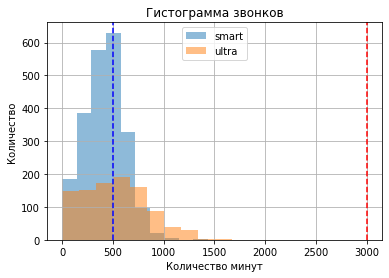

In [97]:
report_tariff['sum_calls'].plot(kind='hist', bins=10, alpha=0.5, grid=True, title='Гистограмма звонков', legend=True)
plt.axvline(500, color="blue", linestyle="--")
plt.axvline(3000, color="red", linestyle="--")
plt.xlabel('Количество минут')
plt.ylabel('Количество')
plt.show()

На тарифе "Смарт" болшинство абонентов расходуют минуты в рамках предоставленного лимита.  

На тарифе "Ультра" абоненты практически не расходуют лимит.  

Среднее значение звонков за месяц практически одинаково на обоих тарифах.

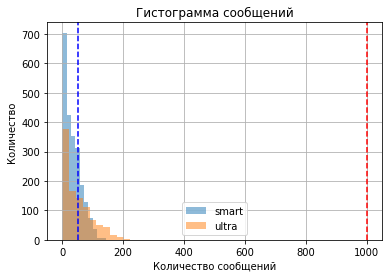

In [98]:
report_tariff['count_messages'].plot(kind='hist', bins=10, alpha=0.5, grid=True, title='Гистограмма сообщений', legend=True)
plt.axvline(50, color="blue", linestyle="--")
plt.axvline(1000, color="red", linestyle="--")
plt.xlabel('Количество сообщений')
plt.ylabel('Количество')
plt.show()

Большие группы абонентов не используют или мало используют смс-сообщения.  

Можно сказать что в среднем каждый абонент отправляет порядка 50 сообщений.  

На тарифе "Ультра" ни один из пользователей не расходует лимит больше, чем на 25%. 

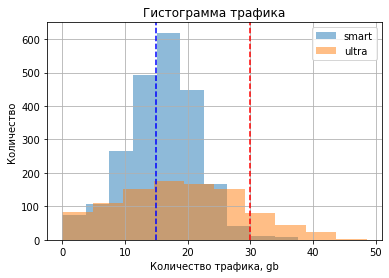

In [99]:
report_tariff['sum_gb'].plot(kind='hist', bins=10, alpha=0.5, grid=True, title='Гистограмма трафика', legend=True)
plt.axvline(15, color="blue", linestyle="--")
plt.axvline(30, color="red", linestyle="--")
plt.xlabel('Количество трафика, gb')
plt.ylabel('Количество')
plt.show()

На тарифе "Смарт" большинство абонентов расходуют интернет-трафыик в пределах лимита, в среднем 16 Гб.  

На тарифе "Ультра" также большинство абонентов расходуют трафик в рамках лимита, в среднем 20 ГБ.

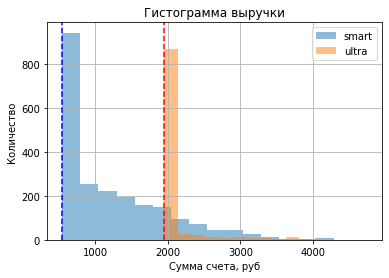

In [100]:
report_tariff['revenue'].plot(kind='hist', bins=15, alpha=0.5, grid=True, title='Гистограмма выручки', legend=True)
plt.axvline(550, color="blue", linestyle="--")
plt.axvline(1950, color="red", linestyle="--")
plt.xlabel('Сумма счета, руб')
plt.ylabel('Количество')
plt.show()

На тарифе "Смарт" чаще платят сверх тарифа, а абоненты "Ультра" чаще платят изначально обозначенную ежемесячную плату.

In [101]:
report_tariff['revenue'].describe()

,count,mean,std,min,25%,50%,75%,max
tariff_name,,,,,,,,
smart,2230.0,1204.040063,727.594734,550.0,550.0,953.655,1647.245,4281.77
ultra,986.0,2059.757444,354.717830,1950.0,1950.0,1950.000,1950.000,4736.97


#### Вывод

Количество абонентов на тарифе **"Смарт"** - 351, на тарифе **"Ультра"** - 149.  

Проанализировав расходы абонентов можно сказать следующее:
- Среднее значение звонков за месяц практически одинаково на обоих тарифах.
- В среднем каждый абонент отправляет порядка 50 сообщений. 
- Средний расход интернет-трафика на тарифе **"Ультра"** выше.
- На тарифе **"Смарт"** чаще платят сверх тарифа, а абоненты **"Ультра"** чаще платят изначально обозначенную ежемесячную плату.  

Можно предположить что клиенты выбирают тариф **"Ультра"** из-за большего лимита интернет-трафика.

### Проверим гипотезы

#### Гипотеза 1 - Cредняя выручка пользователей тарифов «Ультра» и «Смарт» различается

Выведем значения с выручкой в отдельный столбец для каждого тарифа:

In [102]:
smart_test_1 = report_smart['revenue']

In [103]:
ultra_test_1 = report_ultra['revenue']

In [104]:
var_smart_test_1 = np.var(smart_test_1)

In [105]:
var_ultra_test_1 = np.var(ultra_test_1)

In [106]:
(var_smart_test_1, var_ultra_test_1)

(529156.7002207136, 125697.12737034424)

In [107]:
if (abs((var_ultra_test_1/var_smart_test_1)-1) < 0.05):
    print('equal_var = True')
else:
    print('equal_var = False')

equal_var = False


Дисперсии выборок отличаются больше, чем на 5% следовательно параметр *equal_var = False*

Проведем T-тест, который позволяет определить, вероятность того, что две выборки (расходы абонентов тарифов "Смарт" и "Ультра") имеют одно и то же среднее.

In [108]:
alpha = 0.05 # критический уровень статистической значимости
            # если p-value окажется меньше него - отвергнем гипотезу

results = st.ttest_ind(
    ultra_test_1, 
    smart_test_1, equal_var = False)

print('p-значение: {}'.format(results.pvalue))

p-значение: 0.0


In [109]:
if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 

Отвергаем нулевую гипотезу


P-значение на много меньше доверительного интервала, вероятность того что средние не равны очень высокая.  

Учитывая, то в основе T-тест сформулирована нулевая гипотеза о равенстве двух средних, можно с уверенностью сказать, что **_средняя выручка на тарифах различна._**

Посчитаем средние выручки на тарифах:

In [110]:
print('Средняя выручка на тарифе "Смарт": {:.2f}'.format(smart_test_1.mean()))
print('Средняя выручка на тарифе "Ультра": {:.2f}'.format(ultra_test_1.mean()))

Средняя выручка на тарифе "Смарт": 1204.04
Средняя выручка на тарифе "Ультра": 2059.76


Действительно абоненты тарифа **"Ультра"** тратят в среднем больше, чем абоненты тарифа **"Смарт""**

#### Гипотеза 2 - Cредняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов

Добавим к таблице данные о городе подключения абонентов:

In [111]:
report_test_2 = report_true.merge(users,how='left',on=['user_id'])

Сделаем срезы, для того чтобы выделить абонентов из Москвы и других городов

In [112]:
moscow = report_test_2.query('city == "Москва"')

In [113]:
moscow.head()

,user_id,tariff_name_x,month,count_calls,sum_calls,sum_mb_used,count_messages,messages_included,mb_per_month_included,minutes_included,...,sum_gb,age,churn_date,city,first_name,last_name,reg_date,tariff_name_y,days_connect,status_user
8,1003,ultra,8.0,55.0,380.0,8565.21,37.0,1000,30720,3000,...,8.364463,23,2021-05-10,Москва,Белла,Белякова,2018-08-17,ultra,997 days,действующий
9,1003,ultra,9.0,134.0,961.0,12468.87,91.0,1000,30720,3000,...,12.176631,23,2021-05-10,Москва,Белла,Белякова,2018-08-17,ultra,997 days,действующий
10,1003,ultra,10.0,108.0,855.0,14768.14,83.0,1000,30720,3000,...,14.422012,23,2021-05-10,Москва,Белла,Белякова,2018-08-17,ultra,997 days,действующий
11,1003,ultra,11.0,115.0,824.0,11356.89,94.0,1000,30720,3000,...,11.090713,23,2021-05-10,Москва,Белла,Белякова,2018-08-17,ultra,997 days,действующий
12,1003,ultra,12.0,108.0,802.0,10121.53,75.0,1000,30720,3000,...,9.884307,23,2021-05-10,Москва,Белла,Белякова,2018-08-17,ultra,997 days,действующий


In [114]:
other = report_test_2.query('city != "Москва"')

In [115]:
test_moscow = moscow['revenue']

In [116]:
test_other = other['revenue']

Рассчитаем дисперсию для установки верного параметра equal_var при проведении теста:

In [117]:
var_test_moscow = np.var(test_moscow)

In [118]:
var_test_other = np.var(test_other)

In [119]:
var_test_moscow, var_test_other

(518947.8211951292, 570717.8798704227)

In [120]:
if (abs((var_test_moscow/var_test_other)-1) < 0.05):
    print('equal_var = True')
else:
    print('equal_var = False')

equal_var = False


Дисперсии выборок отличаются больше, чем на 5% следовательно параметр *equal_var = False*

Проведем T-тест, и вычисилм вероятность того, что средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов

In [121]:
alpha = 0.05 # критический уровень статистической значимости
            # если p-value окажется меньше него - отвергнем гипотезу

results2 = st.ttest_ind(
    test_moscow, 
    test_other, equal_var = False)

print('p-значение:', results2.pvalue)

p-значение: 0.21913161534355155


In [122]:
if (results2.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 

Не получилось отвергнуть нулевую гипотезу


В предыдущем тесте мы легко смогли отвергнуть нулевую гипотезу о равенстве двух выборок, в этом же эксперименте мы этого сделать не можем, т.к. p-value находится в рамках доверительного интервала. Следовательно утверждать, что ***выручка абонентов Москвы и других городов - вероятней одинакова.***

Проверим средние значения выручек для Москвы и других городов:

In [123]:
print('Средняя выручка абонентов Москвы: {:.2f}'.format(test_moscow.mean()))
print('Средняя выручка абонентов других городов: {:.2f}'.format(test_other.mean()))

Средняя выручка абонентов Москвы: 1498.98
Средняя выручка абонентов других городов: 1458.75


#### Формулировка нулевой и альтернативной гипотезы:

##### Формулировки теста №1

H0 - Cредняя выручка на тарифах «Ультра» и «Смарт» равна

Н1 - Cредняя выручка на тарифах «Ультра» и «Смарт» различна

##### Формулировки теста №2

H0 - Cредняя выручка пользователей из Москвы и других регионов равна

Н1 - Cредняя выручка пользователей из Москвы и других регионов различна

#### Какой критерий использовали для проверки гипотез и почему?

В данных экспериментах мы использовали T-критерий Стьюдента для количественной оценки разницы между средним двух независимых выборок данных. Данный метод мы можем использовать при нормальном распределении данных. В гистограмме выручки можно заметить, что данные распределены нормально со сдвигом вправо.

### Общий вывод

Для изучения предоставлено 5 различных файлов с данными. Практически в каждом указан не верный формат столбцов с датой. Значения пропущенны лишь в одной таблице, для абонентов все еще являющимися клиентами компании. Дубликаты отсутствуют.  

С помощью группировки мы вычисилил для каждого абонента помесячно:  
1) количество сделанных звонков и израсходованных минут разговора;  
2) количество отправленных сообщений по месяцам;  
3) объем израсходованного интернет-трафика по месяцам;  
4) помесячную выручку.  

Было обнаружено, что пользователи не всегда используют все услуги телеком компании.

38 абонентов из 500 перестали пользоваться услугами компании.  
Количество абонентов на тарифе "Смарт" - 351, на тарифе "Ультра" - 149.  

**Выводы из анализа расходов абонентов:**
- Среднее значение звонков за месяц практически одинаково на обоих тарифах.
- В среднем каждый абонент отправляет порядка 50 сообщений.
- Средний расход интернет-трафика на тарифе "Ультра" выше.
- На тарифе "Смарт" чаще платят сверх тарифа, а абоненты "Ультра" чаще платят изначально обозначенную ежемесячную плату.

Следует проверить вероятность выбора абонентами тарифа "Ультра" из-за большего лимита интернет-трафика.  


**Результаты проверки гипотез:**
- средняя выручка на тарифах **"Смарт"** и **"Ультра"** различна;
- выручка абонентов Москвы и других городов - вероятней ***одинакова***.

**Полученные справочные данные:**  

Средняя выручка на тарифе "Смарт": 1204.04  
Средняя выручка на тарифе "Ультра": 2059.76  
Средняя выручка абонентов Москвы: 1498.98  
Средняя выручка абонентов других городов: 1458.75 

 
 
**Тариф "Ультра" является более рентабельным для компании и позволяет сгенерировать большую выручку.**

**Рекомендации:**
- уменьшить отток клиентов;
- предлагать клиентам "Смарт" более дорогой тариф "Ультра".